# Lesson 12 - Introduction to Diffusion Models

Diffusion models are a little different to the other types of generative models you may have encountered. During training, input images (or any other kind of data) are corrupted, and the model attempts to 'undo' this corruption. Once trained, we can begin from a random set of inputs that resembles data that has been so completely degraded as to be unrecognizeable and then gradually 'uncorrupt' this, typically over a large number of steps.

TODO diagram

In most (but not all!) current approaches, this 'corruption' takes the place of adding noise, hence 'denoising diffusion models'. The exact method of adding noise and the details of how the problem is formulated vary across the literature, which can lead to confusion.

The goal of this lesson is to introduce the key concepts without worrying too much about specific implementations. The plan:

- Start with a simplistic toy example
- Discuss some issues with it, and try a few improvements
- Try an existing implementation, exploring the differences between this and our toy version
- Along the way we'll define some key terms and highlight some additional questions that will be addressed in later lessons. Ready? Let's go!

In [ ]:
#
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tglcourse.data_utils import get_mnist_dl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## A Toy Example

![toy photo](https://images.pexels.com/photos/12211/pexels-photo-12211.jpeg?cs=srgb&dl=pexels-tetyana-kovyrina-12211.jpg&fm=jpg&w=640&h=427)

[video: intro idea]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Image shape: torch.Size([1, 28, 28])
Image min and max: tensor(0.) tensor(1.)
label: 5


<matplotlib.image.AxesImage>

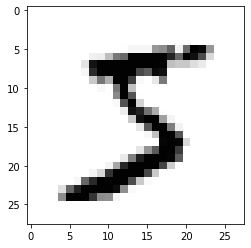

In [ ]:
#notest
# Load the dataset (replace MNIST with FashionMNIST for a variant)
mnist_dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
# View an example
im, label = mnist_dataset[0]
print('Image shape:', im.shape)
print('Image min and max:', im.min(), im.max())
print('label:', label)
plt.imshow(im[0], cmap='Greys')

In [ ]:
# See how we can make a dataloader to serve the data in batches for training
train_dataloader = DataLoader(mnist_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
x.shape, y

(torch.Size([8, 1, 28, 28]), tensor([5, 0, 1, 7, 6, 3, 2, 9]))

### The Corruption Process

Pretend you haven't read any diffusion model papers, but you know the process involves adding noise. How would you do it?

We probably want an easy way to control the amount of corruption. So what if we take in a parameter for the `amount` of noise to add, and then we do:

`noise = torch.rand_like(x)` 

`noisy_x =  (1-amount)*x + amount*noise`

If amount = 0, we get back the input without any changes. If amount gets up to 1, we get back noise with no trace of the input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1).

We can implement this fairly easily (just watch the shapes so you don't get burnt by broadcasting rules): 

In [ ]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount 

And looking at the results visually to see that it works as expected:

<matplotlib.image.AxesImage>

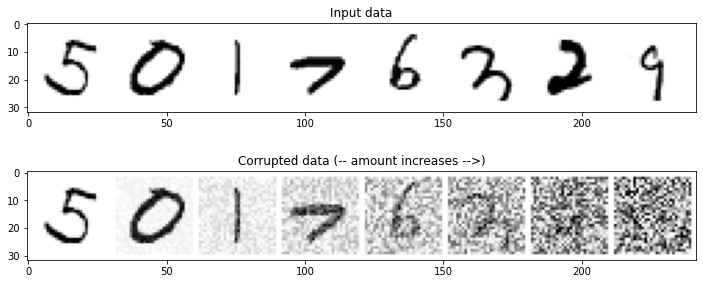

In [ ]:
# Visualize the process
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

axs[1].set_title('Corrupted data (-- amount increases -->)')
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

With this in place, let's move on to the next piece of this process - the model.

### The Model (take 1)

Sticking with our goal of simplicity, we'll specify the model here as a convolutional neural network that produces an output the same shape as it's input:

In [ ]:
class BasicConvNet(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size=5, hidden_channels = 32):
        super().__init__()
        padding = kernel_size // 2 # So we keep output size the same
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size, padding=padding),
        )

    def forward(self, x):
        return self.net(x)

We can create one and feed our demo batch of data through to check that it works and that the output shape is the same as the input as we expect:

In [ ]:
# Create the network (for single channel input & output images)
net = BasicConvNet(1, 1)

# Feed some data through:
x.shape, net(x).shape

(torch.Size([8, 1, 28, 28]), torch.Size([8, 1, 28, 28]))

# Training the network

So what should the model do, exactly? Again, there are various takes on this but for this demo let's pick a simple framing: given a corrupted input noisy_x the model should output its best guess for what the original x looks like. We will compare this to the actual value via the mean squared error

We can now have a go at training the network. 
- Get a batch of data
- Corrupt it by random amounts
- Feed it through the model
- Compare the model predictions with the clean images to calculate our loss
- Update the model's parameters accordingly.

Feel free to experiment with all of the parameters here - for this example I chose most fairly arbitrarily!

Starting epoch 0
Average of the last 100 loss values: 0.018669046107679606
Starting epoch 1
Average of the last 100 loss values: 0.017594433799386026
Starting epoch 2
Average of the last 100 loss values: 0.017140451464802028
Starting epoch 3
Average of the last 100 loss values: 0.01618829969316721
Starting epoch 4
Average of the last 100 loss values: 0.015353951528668404
Starting epoch 5
Average of the last 100 loss values: 0.013952187476679683
Starting epoch 6
Average of the last 100 loss values: 0.013618417792022228
Starting epoch 7
Average of the last 100 loss values: 0.012858736589550971
Starting epoch 8
Average of the last 100 loss values: 0.012800483955070377
Starting epoch 9
Average of the last 100 loss values: 0.012588022695854306


[<matplotlib.lines.Line2D>]

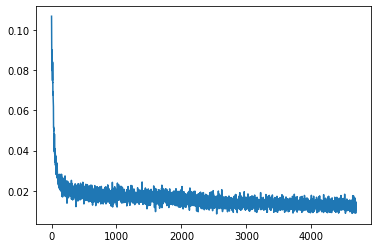

In [ ]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network (try changing hidden_channels and n_layers)
net = BasicConvNet(1, 1, hidden_channels=64)
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=5e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_basic = []

# The training loop
for epoch in range(n_epochs):
    print(f'Starting epoch {epoch}')
    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        
        # break

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_basic.append(avg_loss)
    print('Average of the last 100 loss values:', avg_loss)

# View the loss curve
plt.plot(losses)

We can try to see what the model predictions look like by grabbing a batch of data, corrupting it my different amounts and then seeing the models predictions:

<matplotlib.image.AxesImage>

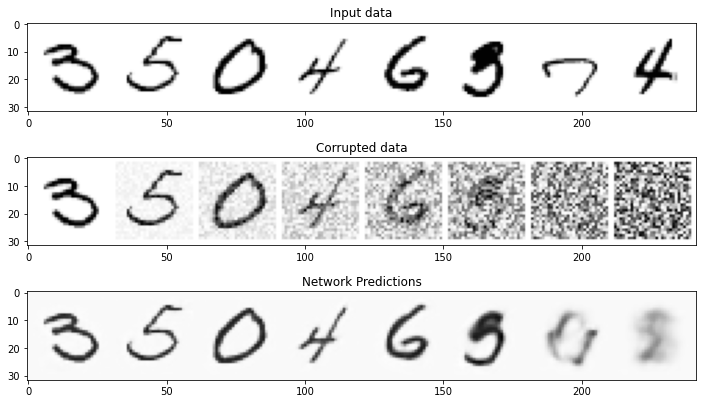

In [ ]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0], cmap='Greys')

You can see that for the lower amounts the predictions are pretty good! But as the level gets very high there is less for the model to work with, and by the time we get to amount=1 it outputs something close to the mean of the dataset to try and hedge its bets on what the output might look like.

**Think**: Does that final sentence make sense?

# Sampling

As we just saw, feeding pure noise into the model doesn't give a prediction that looks much like a digit! We need a sampling strategy. Again, pretend we're trying this without peeking at any existing papers and that the words 'differential equation' are an alien language. 

When the model sees a very corrupted input it doesn't have much information to go on, but perhaps there's a darker region that might indicate some ink near the top - perhaps a 7 or a 5. For an image with less noise, perhaps more structure becomes clear - a 5 or perhaps an 8? Based on this, perhaps we can gradually approach the goal? Let's think about it through an analogy:

[placeholder image]

There's a cool volcano explosion happening somewhere, and you want to visit it and take photos. You look around, and the western horizon seems darker. You head that way, and even though you didn't quite guess the exact direction right, when you next park the car and look around you can see some hazy hills by a lake in the distance. It looks like one of them is the source of the smoke. As you pull up near the water, it is clear which hill is covered in lava, and how far away it is. Out comes the camera and you get a journalism prize.

Far fetched perhaps, but let's translate this back to the problem at hand and see if we get anywhere:

- The model predictions for high noise amounts aren't great, but might at least partly show us a fruitful direction to explore. 
- If we just move a little in that direction, we should then be able to make a better prediction and move a bit closer...
- Repeat this enough and hopefully we'll get a good result!

Putting it in pseudo-code:
```
steps = 10
x = random noise to start
for i in range(steps):
  pred = model(x)
  x = a mix of x and pred
```

And in code, visualizing the steps along the way:

TODO second column of fig showing model predictions

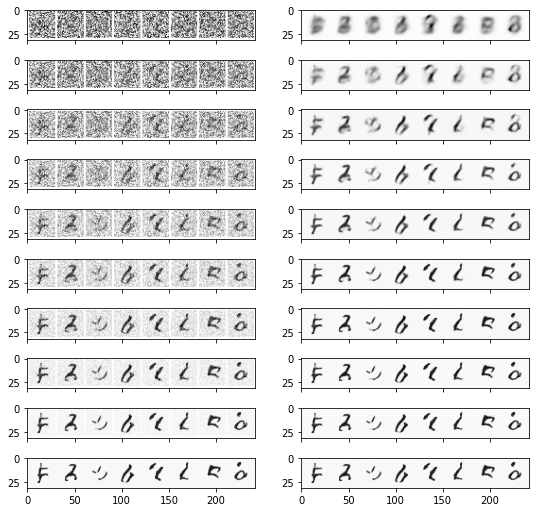

In [ ]:
# Take one: just break the process into 10 steps and take 1/10'th of a step each time:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = []
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there # Should it be (pred-x) instead of pred?
    step_history.append(x.detach().cpu()) # Store for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys'),
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0], cmap='Greys')


TODO explain the two columns.

### Making the model's job easier: Noise Conditioning

At the moment the model gets a noisy_x and tries to predict the original just based on that. It seems intuitive that if we can find a way to slip the model extra info in the form of a hint, it should be able to do a better job. So, to start with, let's make a version that can receive info about how much noise has been added:

In [ ]:
class NoiseConditionedConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        
        padding = kernel_size // 2
        self.net = nn.Sequential(
            nn.Conv2d(in_channels+1, 16, kernel_size,  padding=padding), # <<< 1 extra input channel
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size, padding=padding),
        )

    def forward(self, x, noise_amount):
        # Shape of x
        bs, ch, w, h = x.shape
        
        # Get noise_amount as a single channel 'image' the same shape as x
        if not torch.is_tensor(noise_amount):
            noise_amount = x.new_full((x.size(0),), noise_amount)
        noise_amount = noise_amount.view(-1, 1, 1, 1).expand(bs, 1, w, h) # If x.shape is [8,3,28,28] noise_amount is [8,1,28, 28]
        
        # Concatenate this onto x to get the final net input:
        net_input = torch.cat((x, noise_amount), 1)
        
        # Now pass through the net to get the prediction as before
        return self.net(net_input)

# Creating a network
net = NoiseConditionedConvNet(1, 1)

# Now we need both x and noise_amount to make predictions:
x, y = next(iter(train_dataloader))
bs = x.shape[0]
noise_amount = torch.rand([bs])
x.shape, net(x, noise_amount).shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

All we do here in add a second channel to the input image with the noise amount as the value for all 'pixels'. 

Starting epoch 0
Average of the last 100 loss values: 0.018453519996255635
Starting epoch 1
Average of the last 100 loss values: 0.016609850460663437
Starting epoch 2
Average of the last 100 loss values: 0.014696632102131844
Starting epoch 3
Average of the last 100 loss values: 0.01351835892535746
Starting epoch 4
Average of the last 100 loss values: 0.012509688967838883
Starting epoch 5
Average of the last 100 loss values: 0.012411500830203294
Starting epoch 6
Average of the last 100 loss values: 0.01217438256368041
Starting epoch 7
Average of the last 100 loss values: 0.012190472465008498
Starting epoch 8
Average of the last 100 loss values: 0.011665145535953342
Starting epoch 9
Average of the last 100 loss values: 0.011641120496205986


[<matplotlib.lines.Line2D>]

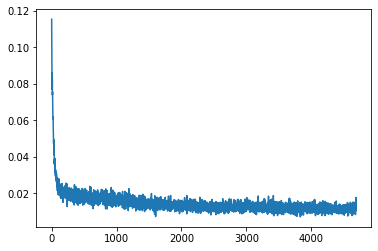

In [ ]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our new network type: 
net = NoiseConditionedConvNet(1, 1) # <<< Using our new noise conditioned net
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=5e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_noise_cond = []

# The training loop
for epoch in range(n_epochs):
    print(f'Starting epoch {epoch}')
    for x, y in train_dataloader:
        
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, noise_amount) # <<<<<<

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_noise_cond.append(avg_loss)
    print('Average of the last 100 loss values:', avg_loss)

# View the loss curve
plt.plot(losses)

The loss is marginally lower. But there's something I want to note here: A decent network should be trivially capable of seeing whether a given input is super noisy or not. And so this noise conditioning might not be necessary - in fact in tests I've found that it doesn't seem to make any difference! And yet this is used everywhere, largely as an artifact of the historical framing of diffusion models.

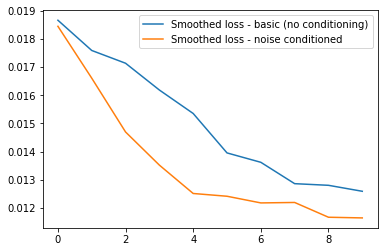

In [ ]:
plt.plot(smoothed_losses_basic, label='Smoothed loss - basic (no conditioning)')
plt.plot(smoothed_losses_noise_cond, label='Smoothed loss - noise conditioned')
plt.legend();

Anyway, our sampling loop looks roughly the same as before except now we need to pass a noise_amount to the model at each step. Here I assume it goes linearly from 1 to 0 over the course of sampling but THIS IS NOT NECESSARILY RIGHT. Sampling schemes usually explicity account for the timestep in the update, as we'll see when we look at the DDPM version.

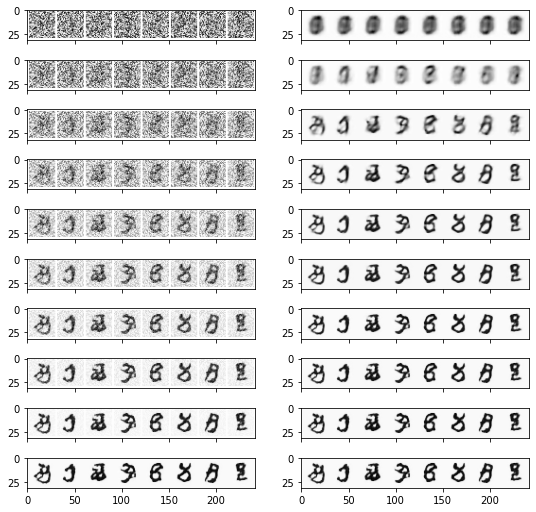

In [ ]:
# Sampling as before, but conditioning on an estimated noise amount:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = []
pred_output_history = []

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x, noise_amount) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there # Should it be (pred-x) instead of pred?
    step_history.append(x.detach().cpu()) # Store for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys'),
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0], cmap='Greys')

<matplotlib.image.AxesImage>

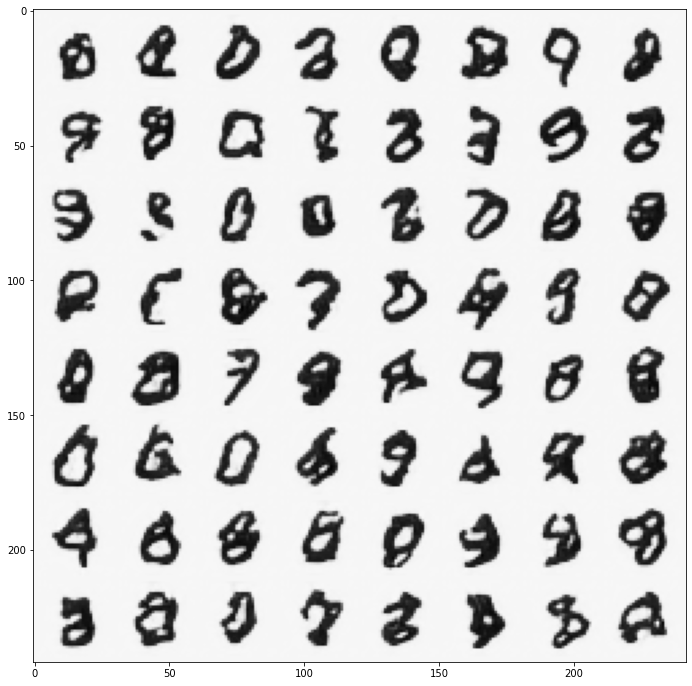

In [ ]:
# Try some at higher steps
n_steps = 100 # Try 2, 5, 10, 50 - how does it affact things?
x = torch.rand(64, 1, 28, 28).to(device)
history = [x.detach().cpu()]

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
    with torch.no_grad():
        pred = net(x, noise_amount)
    mix_factor = 1/(n_steps - i) # Explain how we're moving linearly towards the solution
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

## Class Conditioning

In [ ]:
class NoiseAndClassConditionedConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes=10, class_emb_channels=4, kernel_size=5):
        super().__init__()
        
        padding = kernel_size // 2 # TO keep output size the same
        self.class_emb = nn.Embedding(num_classes, class_emb_channels) # Map num_classes discrete classes to class_emb_channels numbers
        self.net = nn.Sequential(
            nn.Conv2d(in_channels+1+class_emb_channels, 16, kernel_size,  padding=padding), # <<< 1 extra input channel for noise + class_emb_channels for class conditioning
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size,  padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size, padding=padding),
        )

    def forward(self, x, noise_amount, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape
        
        # Get noise_amount the same shape as x
        if not torch.is_tensor(noise_amount):
            noise_amount = x.new_full((x.size(0),), noise_amount)
        noise_amount = noise_amount.view(-1, 1, 1, 1).expand(bs, 1, w, h)
        
        # And the class cond
        class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
        class_cond_channels = class_cond.shape[1]
        class_cond = class_cond.view(bs, class_cond_channels, 1, 1).expand(bs, class_cond_channels, w, h) # Reshape
        
        net_input = torch.cat((x, noise_amount, class_cond), 1)
        return self.net(net_input)
    
# Creating a network
net = NoiseAndClassConditionedConvNet(1, 1)

# Now we need x, noise_amount AND y to make predictions:
x, y = next(iter(train_dataloader))
bs = x.shape[0]
noise_amount = torch.rand([bs])
x.shape, net(x, noise_amount, y).shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

Starting epoch 0
Average of the last 100 loss values: 0.019969225134700536
Starting epoch 1
Average of the last 100 loss values: 0.016659374991431834
Starting epoch 2
Average of the last 100 loss values: 0.016019560489803554
Starting epoch 3
Average of the last 100 loss values: 0.015124658932909369
Starting epoch 4
Average of the last 100 loss values: 0.014764510840177537
Starting epoch 5
Average of the last 100 loss values: 0.014143051588907838
Starting epoch 6
Average of the last 100 loss values: 0.01293370340950787
Starting epoch 7
Average of the last 100 loss values: 0.012400964060798287
Starting epoch 8
Average of the last 100 loss values: 0.011826970782130956
Starting epoch 9
Average of the last 100 loss values: 0.011578085776418447


[<matplotlib.lines.Line2D>]

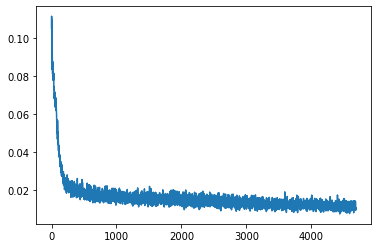

In [ ]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our new network type: 
net = NoiseAndClassConditionedConvNet(1, 1) # <<< Using our new noise and class conditioned net
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=5e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_class_cond = []

# The training loop
for epoch in range(n_epochs):
    print(f'Starting epoch {epoch}')
    for x, y in train_dataloader:
        
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, noise_amount, y.to(device)) # <<<<<<

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_class_cond.append(avg_loss)
    print('Average of the last 100 loss values:', avg_loss)

# View the loss curve
plt.plot(losses)

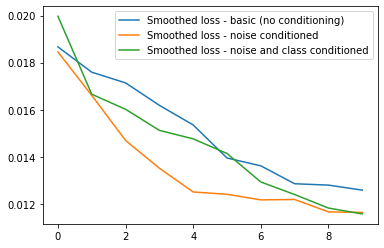

In [ ]:
plt.plot(smoothed_losses_basic, label='Smoothed loss - basic (no conditioning)')
plt.plot(smoothed_losses_noise_cond, label='Smoothed loss - noise conditioned')
plt.plot(smoothed_losses_class_cond, label='Smoothed loss - noise and class conditioned')
plt.legend();

<matplotlib.image.AxesImage>

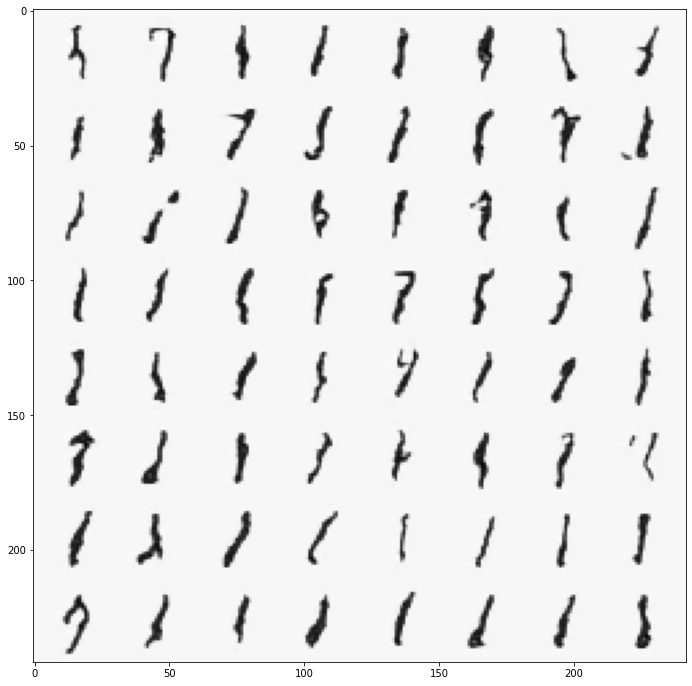

In [ ]:
# Sample a grid of digits
n_steps = 50
x = torch.rand(64, 1, 28, 28).to(device)
digit=1 # Try different digits!
y = torch.ones((64,)).long().to(device)*digit
history = [x.detach().cpu()]

for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, noise_amount, y)
  mix_factor = 1/(n_steps - i) # Explain how we're moving linearly towards the solution
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

<matplotlib.image.AxesImage>

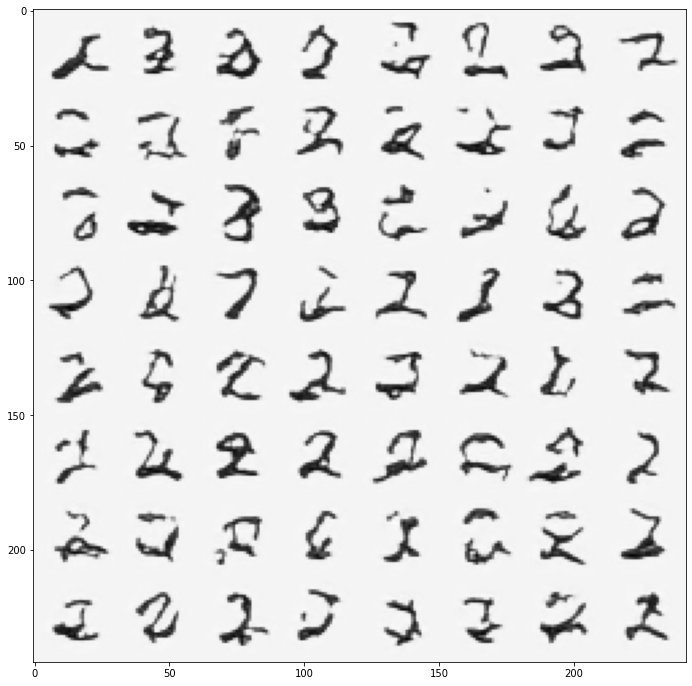

In [ ]:
# Sample a grid of digits
n_steps = 50
x = torch.rand(64, 1, 28, 28).to(device)
digit=2 # Try different digits!
y = torch.ones((64,)).long().to(device)*digit
history = [x.detach().cpu()]

for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, noise_amount, y)
  mix_factor = 1/(n_steps - i) # Explain how we're moving linearly towards the solution
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

<matplotlib.image.AxesImage>

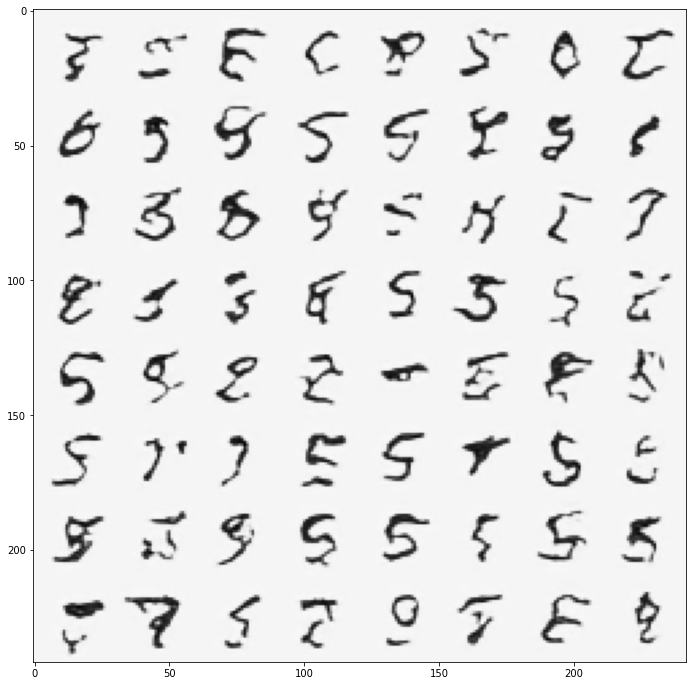

In [ ]:
# Sample a grid of digits
n_steps = 50
x = torch.rand(64, 1, 28, 28).to(device)
digit=5 # Try different digits!
y = torch.ones((64,)).long().to(device)*digit
history = [x.detach().cpu()]

for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, noise_amount, y)
  mix_factor = 1/(n_steps - i) # Explain how we're moving linearly towards the solution
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

<matplotlib.image.AxesImage>

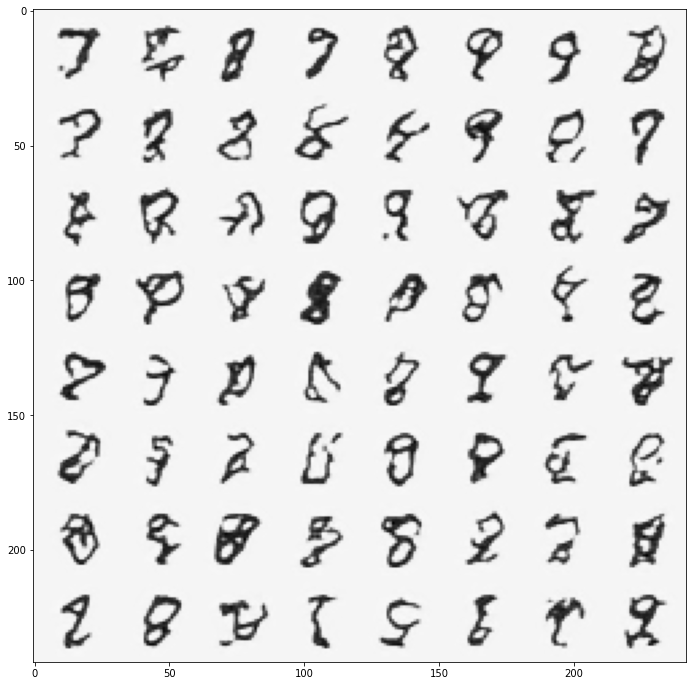

In [ ]:
# Sample a grid of digits
n_steps = 50
x = torch.rand(64, 1, 28, 28).to(device)
digit=8 # Try different digits!
y = torch.ones((64,)).long().to(device)*digit
history = [x.detach().cpu()]

for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, noise_amount, y)
  mix_factor = 1/(n_steps - i) # Explain how we're moving linearly towards the solution
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

### What have we learnt, and how much was a lie?

This exercise has hopefully given at least a conceptual understanding of roughly what is going on here. None of the components are optimal, and there is some extra complexity we'll need to address eventually, but it's not a bad place to start. We've identified the key ingredients for training a diffusion model, namely:
- A method for gradually corrupting the data
- A model of some sort that takes in this corrupted data as inputs
- A plan for how much noise to add, and how to reverse the process during sampling.

Turns out nobody does any of these quite like how we did it. When you see a paper or read an explainer notebook on a new diffusion model variant try to see how they do each bit, and dig into why they made those choices.

Questions we haven't (yet) answered:
- Where does the idea of timesteps come in? What does it mean when people talk about discrete vs continuous time formulations?
- What training objectives are used?
- OK but someone mentioned differential equations?
- Something something variance preserving (VP) or variance exploding (VE)???
- What are better ways to sample with these models?
- What is this unet people keep mentioning?
- How do I control this with text?
- How do 'real' implementations feed in the conditioning for noise level/timestep and for things like text?
- Why is this better than a one-shot approach like a GAN?

# DDPM with the Diffusers library

With the first example held in mind, let's look at an implementation of a diffusion model based on [the DDPM paper] and see how it compares to our toy version above:

# Our 'Toy' Example TO THE MAX

You may be wondering: that toy example, were all those choices terrible? What would this 'naive' corruption method and sampling approach look like if you trained a decent unet model to 'decorrupt' the image? Good news, I made a fastai version and it actually works suprisingly well - and trains much faster than the equivalent DDPM model! 